In [1]:
import torch
import time
import gc
import math
from scipy import ndimage
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../cnn')
from commons import full_inference_e2e, inc_inference_e2e,adaptive_drilldown
from vgg16 import VGG16
from vgg16_inc import IncrementalVGG16

image_file_path = "../cnn/dog_resized.jpg"
interested_logit_index = 208

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# torch.cuda.synchronize()
prev_time = time.time()
outputs_full = full_inference_e2e(VGG16, image_file_path, 16, 2, interested_logit_index,
                                  batch_size=256)
torch.cuda.synchronize()
full_inference_time = time.time() - prev_time
print("Full Inference Time: " + str(full_inference_time))

Full Inference Time: 27.1688430309


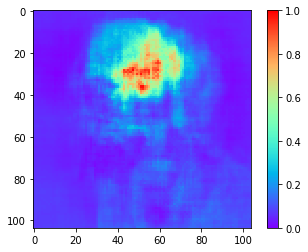

In [3]:
x = outputs_full
xmax, xmin = x.max(), x.min()
x = 1 - (x - xmin)/(xmax - xmin)

outputs_full_final = x
np.savetxt('temp', outputs_full_final)

plt.imshow(x, cmap=plt.cm.rainbow, interpolation='none')
plt.colorbar()

In [4]:
gc.collect()
torch.cuda.empty_cache()

In [5]:
def inc_inference(beta, patch_size=4, stride=1):
    torch.cuda.synchronize()
    #outputs_inc = inc_inference_e2e(IncrementalVGG16, image_file_path, patch_size, stride, interested_logit_index,
    #                                batch_size=128, beta=beta)
    outputs_inc = adaptive_drilldown(IncrementalVGG16, image_file_path, patch_size, stride, interested_logit_index,
                                    batch_size=128, beta=beta, threshold=0.8)
    torch.cuda.synchronize()
    x = outputs_inc
    
    #if beta != 1.0:
    #    x = ndimage.gaussian_filter(x, sigma=0.75*(0.5/beta)**2)

    xmax, xmin = x.max(), x.min()
    x = 1 - (x - xmin)/(xmax - xmin)
    return x

BETA: 1.0 Inference Time: 4.52265906334


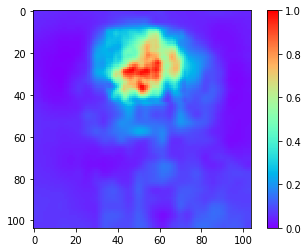

BETA: 0.9 Inference Time: 4.2750248909


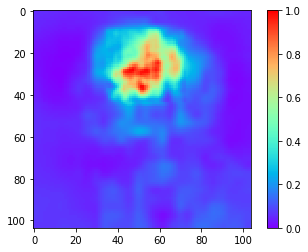

BETA: 0.8 Inference Time: 4.25432610512


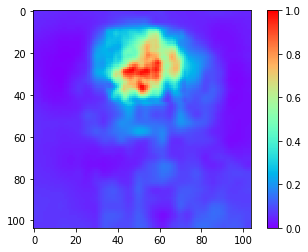

BETA: 0.7 Inference Time: 4.11064195633


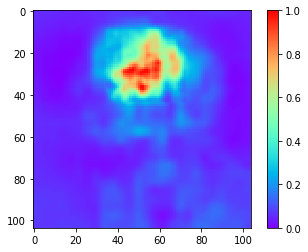

BETA: 0.6 Inference Time: 4.05332994461


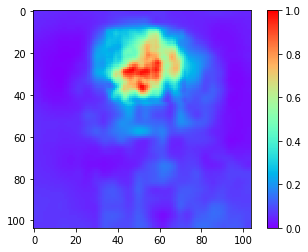

BETA: 0.5 Inference Time: 3.91674208641


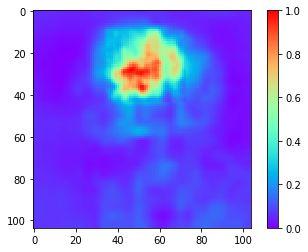

BETA: 0.4 Inference Time: 3.83781814575


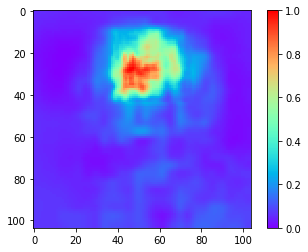

BETA: 0.3 Inference Time: 3.56330108643


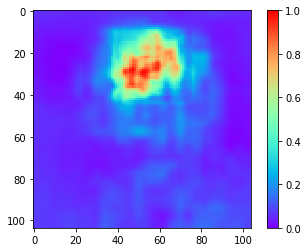

In [6]:
outputs_full_final = np.loadtxt('temp')
times = []
mse = []

for beta in [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3]:
    prev_time = time.time()
    outputs_inc_final = inc_inference(beta, patch_size=16, stride=2)
    inc_inference_time = time.time()-prev_time
    times.append(inc_inference_time)
    mse.append(((outputs_inc_final - outputs_full_final) ** 2).mean(axis=None))
    
    plt.imshow(outputs_inc_final, cmap=plt.cm.rainbow, interpolation='none')
    plt.colorbar()
    label = "BETA: " + str(beta) +" Inference Time: " + str(inc_inference_time)
    print(label)
    plt.show()

Text(0,0.5,u'MSE')

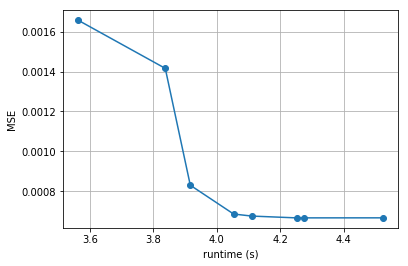

In [7]:
plt.plot(times, mse, marker='o')
plt.grid()
plt.xlabel('runtime (s)')
plt.ylabel('MSE')

In [8]:
outputs_full_final = np.loadtxt('temp')
temp = np.abs(np.around(outputs_full_final, decimals=3) - np.around(outputs_inc_final, decimals=3))

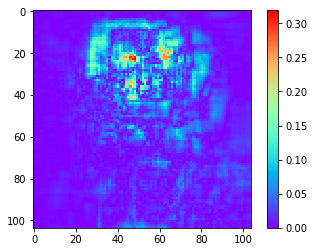

In [9]:
plt.imshow(temp, cmap=plt.cm.rainbow, interpolation='none')
plt.colorbar()